In [1]:
import os
import cv2
import PIL.Image as Image
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

In [2]:
gpu_bool = torch.cuda.is_available()
gpu_bool

True

In [3]:
#!unzip  /content/drive/My\ Drive/Resized_Img_Mask.zip 
#!unzip  Resized_Img_Mask.zip 

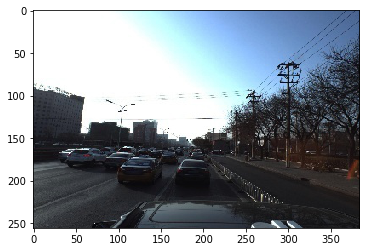

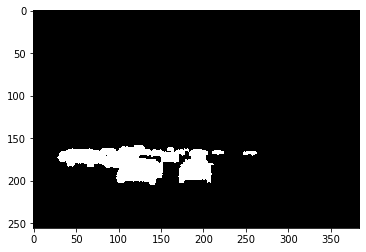

In [4]:
file1 = 'Resized_Img_Mask/4/image.jpg'
file2 = 'Resized_Img_Mask/4/mask.png'
img = plt.imread(file1)
mask = plt.imread(file2)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(mask)

In [5]:
# TODO: Design your own dataset
def convertMask(masks):
  """this function get the mask tensor (batchsize, 1, H, W) and returns a target tensor 
  with dimension (batchsize, 2, H, W), which is a ground truth probability.
  2 is the class number
  """
  return torch.cat(((masks == 0).float(),(masks == 255).float()), 0)

class ImageDataset(Dataset):
    def __init__(self, input_dir, transform = None):
      self.input_dir = input_dir
      self.transform = transform
      self.trans = transforms.ToTensor()
      self.image = []
      self.mask = []
      self.num = [] # the number of active channel
    def transformation(self, images, masks):
      if torch.randperm(2)[0]:
        images = TF.hflip(images)
        masks = TF.hflip(masks)
      if torch.randperm(2)[0]:
        images = TF.vflip(images)
        masks = TF.vflip(masks)
      
      return self.trans(images), self.trans(masks)*255

    def __len__ (self):
        return sum([str.isdigit(s) for s in os.listdir(self.input_dir)])

    def __getitem__(self, idx):
      path_image = self.input_dir + str(idx) + "/"+'image.jpg'
      path_mask = self.input_dir + str(idx) + "/"+'mask.png'
      
      if os.path.exists(path_image) and os.path.exists(path_mask):
        self.image = Image.open(path_image)
        self.mask = Image.open(path_mask)

      if self.transform:
        self.image, self.mask = self.transformation(self.image, self.mask)
      else:
        self.image = self.trans(self.image)
        self.mask = (self.trans(self.mask)).long()
      
      #print(self.mask.shape)
      self.mask = self.mask[0,:,:].reshape(1,256,384)

      return self.image, self.mask, 

train_batch_size = 10
train_path = 'Resized_Img_Mask/'
train_dataset = ImageDataset(train_path, transform=False)
a, b= train_dataset[0][0], train_dataset[0][1]
print(a.shape,b.shape)
#print(b[0,180,:])


torch.Size([3, 256, 384]) torch.Size([1, 256, 384])


In [8]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out,),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

# Upsampling
def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    #TODO: Design your last layer & activations
    self.conv4m= add_conv_stage(32, 32, useBN=useBN)
    self.conv_Final = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)

    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)
     
    conv1m_out = self.conv4m(conv1m_out)
    onv1m_out = self.conv4m(conv1m_out)

    output = self.conv_Final(conv1m_out)
 
    return output



In [9]:
def training_step(model):
  model.train()
  #form the random index
  index = torch.randperm(len(train_dataset))[:train_batch_size].data.numpy()
  
  #get the first index
  image_batch = train_dataset[index[0]][0].reshape(1, 3, 256, 384)
  label_batch = train_dataset[index[0]][1].reshape(1, 1, 256, 384)

  for i in range(len(index)-1):
    a = train_dataset[index[i+1]][0].reshape(1, 3, 256, 384)
    b = train_dataset[index[i+1]][1].reshape(1, 1, 256, 384)
    image_batch = torch.cat((image_batch, a), dim = 0)
    label_batch = torch.cat((label_batch, b), dim = 0)

  if gpu_bool:
    image_batch = image_batch.cuda()
    label_batch = label_batch.cuda()
    #print(image_batch.shape, label_batch.shape)
   
  optimizer.zero_grad()
  output = model(image_batch)
  loss = train_loss(output, label_batch)

  loss.backward()
  optimizer.step()
  #scheduler.step()

  pred = MakePrediction(output)
  #print(pred.shape)

  return loss, DiceScore(pred, label_batch), Accuracy(pred, label_batch)

def val_step(model):
  model.eval()
  #form the random index
  index = torch.randperm(len(val_dataset))[:validation_batch_size].data.numpy()
  #get the first index
  image_batch = val_dataset[index[0]][0].reshape(1, 3, 256, 384)
  label_batch = val_dataset[index[0]][1].reshape(1, 1, 256, 384)
  for i in range(len(index)-1):
    a = val_dataset[index[i+1]][0].reshape(1, 3, 256, 384)
    b = val_dataset[index[i+1]][1].reshape(1, 1, 256, 384)
    image_batch = torch.cat((image_batch, a), dim = 0)
    label_batch = torch.cat((label_batch, b), dim = 0)

  if gpu_bool:
    image_batch = image_batch.cuda()
    label_batch = label_batch.cuda()
    
  output = model(image_batch)
  vali_loss = val_loss(output, label_batch)

  pred = MakePrediction(output)

  return vali_loss, DiceScore(pred, label_batch), Accuracy(pred, label_batch)

In [10]:
def MakePrediction(output):
  """this function get the model output tensor (batchsize, 8, H, W) (without softmax) and returns a prediction tensor
  with dimension (batchsize, 2, H, W), with values of 0 or 1.
  2 is the class number
  """
  softmax = nn.Softmax(dim=1)
  _,d = torch.max(softmax(output), 1, keepdim = True)
  return torch.cat(((d == 0).float(),(d == 1).float()), 1)

def Accuracy(pred, target):
  #target is ground truth label
  #pred is prediction (the output from the MakePrediction)
  batch_size, num_class, H, W = pred.shape
  Accuracy_batch = 0
  for i in range(batch_size):#for each example
    #just use the vehicle channel to predict the accuracy (not background)
    a = pred[i, 1, :, :].float()
    b = target[i, 0, :, :].float()
    Accuracy_batch += torch.sum((torch.abs(a - b) < 1E-5).float())/H/W
  
  Accuracy_batch /= batch_size
  return Accuracy_batch

def DiceScore(pred, target):
  #target is ground truth label
  #pred is prediction (the output from the MakePrediction)
  batch_size, num_class, H, W = pred.shape
  #print(pred.size())
  alpha = 0.0001
  Dice_batch = 0
  for i in range(batch_size):#for each example
    Dice_channel = 0
    #for the vehicle channel
    a = torch.sum(pred[i,1] * target[i,0])
    b = torch.sum(pred[i,1] + target[i,0])
    Dice_channel = ((2*a)/(b))
    Dice_batch += Dice_channel

  return Dice_batch/batch_size

class DICELoss(nn.Module):
  def __init__(self, batch_size = 10, class_num = 2, epilson = 0.0001):
      super(DICELoss, self).__init__()
      self.BS = batch_size
      self.Classnum = class_num
      self.epilson = epilson

  def forward(self, output, target):
    loss_batch = 0
    #pass the output from the unet through a softmax
    softmax = nn.Softmax(dim=1)
    output = softmax(output)
    #print(output.max().item(),output.min().item())
    #print(target.max().item(),target.min().item())
    for i in range(self.BS): #for each example
        #for the vehicle channel
        a = torch.sum(output[i,1,:,:] * target[i,0,:,:])
        b = torch.sum(output[i,1,:,:] + target[i,0,:,:])
        loss_batch += (1 - (2*a)/(b))

    return loss_batch/self.BS



In [12]:
# Batch size can be changed if it does not match your memory, please state your batch step_size in your report.
input_channel = 3
output_channel = 2
H = 256
W = 384

train_batch_size = 25
validation_batch_size = 25

train_path = 'Resized_Img_Mask/'
train_dataset = ImageDataset(train_path, transform=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

val_path = 'Resized_Img_Mask/'
val_dataset = ImageDataset(val_path, transform=False)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=train_batch_size)

# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 200

model_Q1a = unet(useBN=True)
if gpu_bool:
    model_Q1a = model_Q1a.cuda()

optimizer = torch.optim.Adam(model_Q1a.parameters(),lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



#define the loss function
train_loss = DICELoss(batch_size = train_batch_size)#train_batch_size, output_channel)
#val_loss = DICELoss(batch_size = validation_batch_size)#validation_batch_size, output_channel)


#initialize the weight
def weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv2d') != -1 or classname.find('Linear') != -1:
      #print(classname.find('Conv2d'),classname.find('Linear'))
      torch.nn.init.xavier_uniform_(m.weight.data)
model_Q1a.apply(weights_init)


info_train = []
#info_val = []

print("Start Training...")
#fig = plt.figure()
for epoch in range(num_epochs):
  print("Epoch:", epoch)
  #training step
  tra_loss, tra_dice, tra_accuracy = training_step(model_Q1a)#, image_batch, label_batch)
  #print(tra_loss.item())
  print(tra_loss.item(), tra_dice.item(), tra_accuracy.item())

  #validation step
  #with torch.no_grad():
  #  vali_loss, vali_dice, val_accuracy = val_step(model_Q1a)
    #print(vali_loss.item(), vali_dice.item(), val_accuracy.item())


  # if epoch%10 == 0:
  #   print("Trainning loss/dice: " + str(tra_loss.item()) + ', ' + str(tra_dice.item()))
  #   print("Validation loss/dice: " + str(vali_loss.item())+ ', ' + str(vali_dice.item()) + "\n")
  
  #save the data
  info_train.append([epoch, tra_loss.item(), tra_dice.item(), tra_accuracy])
  #info_val.append([epoch, vali_loss.item(), vali_dice.item(), val_accuracy.item()])

Start Training...
Epoch: 0
0.9535348415374756 0.03585556894540787 0.47056764364242554
Epoch: 1
0.913061261177063 0.10756059736013412 0.5570577383041382
Epoch: 2
0.864952802658081 0.15123486518859863 0.5846825838088989
Epoch: 3
0.8354980945587158 0.17730019986629486 0.6019811630249023
Epoch: 4
0.8450331687927246 0.23251551389694214 0.7754626870155334
Epoch: 5
0.8414702415466309 0.24295343458652496 0.8220771551132202
Epoch: 6
0.7937403917312622 0.3018978238105774 0.8422623872756958
Epoch: 7
0.7402082085609436 0.40238475799560547 0.8864749670028687
Epoch: 8
0.7969383597373962 0.3054242730140686 0.8761197328567505
Epoch: 9
0.7103065252304077 0.3347269892692566 0.8365762829780579
Epoch: 10
0.7289972305297852 0.33467188477516174 0.8680362701416016
Epoch: 11
0.7531417012214661 0.3216415047645569 0.8835416436195374
Epoch: 12
0.7233074903488159 0.3607134521007538 0.8969445824623108
Epoch: 13
0.6688503623008728 0.4018019437789917 0.903982400894165
Epoch: 14
0.6578394770622253 0.38611799478530884

0.27957889437675476 0.7214565873146057 0.9792906641960144
Epoch: 123
0.28987953066825867 0.7116758823394775 0.9816805720329285
Epoch: 124
0.41343462467193604 0.5886253118515015 0.9729255437850952
Epoch: 125
0.3925139904022217 0.6094372272491455 0.975945234298706
Epoch: 126
0.3557116985321045 0.645466685295105 0.9796903133392334
Epoch: 127
0.38619863986968994 0.6151630878448486 0.9768945574760437
Epoch: 128
0.3018660247325897 0.6994503140449524 0.9776744842529297
Epoch: 129
0.36993837356567383 0.6313247680664062 0.9751009345054626
Epoch: 130
0.3254493176937103 0.6757447123527527 0.9789240956306458
Epoch: 131
0.30602312088012695 0.6953315734863281 0.9816462993621826
Epoch: 132
0.37503740191459656 0.6255379915237427 0.9670194983482361
Epoch: 133
0.4091155230998993 0.5916720628738403 0.9667178988456726
Epoch: 134
0.3880295753479004 0.6133478879928589 0.9754219651222229
Epoch: 135
0.3366391062736511 0.6650323867797852 0.9750261306762695
Epoch: 136
0.2872127294540405 0.7144923210144043 0.980

Text(0, 0.5, 'Accuracy: percent')

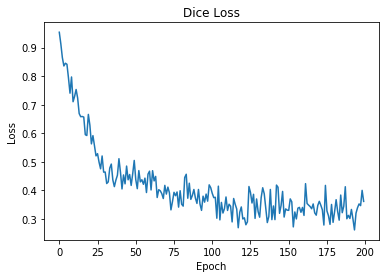

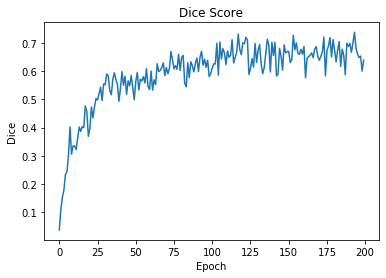

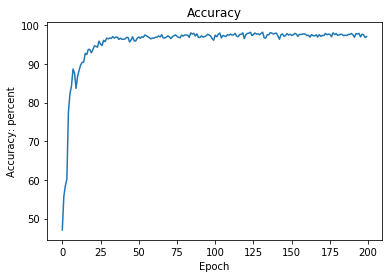

In [14]:
#visualize the data
data_train = np.array(info_train)
#print(data_train.shape)
#data_val = np.array(info_val)
#plot the dice loss
plt.figure()
Dice_train, = plt.plot(data_train[:,0], data_train[:,1], label='Training Loss')
#Dice_val, = plt.plot(data_val[:,0], data_val[:,1], label='Validation Loss')
plt.title("Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.legend(handles=[Dice_train, Dice_val])
#plot the dice score
plt.figure()
Dice_train, = plt.plot(data_train[:,0], data_train[:,2], label='Training Dice Score')
#Dice_val, = plt.plot(data_val[:,0], data_val[:,2], label='Validation Dice Score')
plt.title("Dice Score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
#plt.legend(handles=[Dice_train, Dice_val])

#plot the accuracy
plt.figure()
Dice_train, = plt.plot(data_train[:,0], data_train[:,3]*100, label='Training Accuracy')
#Dice_val, = plt.plot(data_val[:,0], data_val[:,3]*100, label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy: percent")
#plt.legend(handles=[Dice_train, Dice_val])


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type unet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/

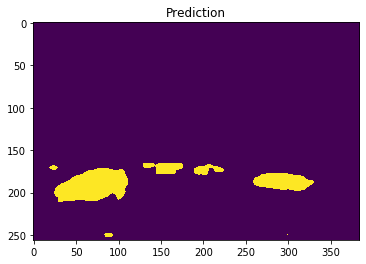

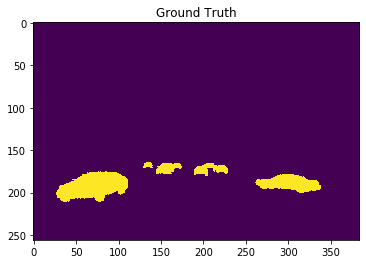

In [26]:
import matplotlib.pyplot as plt

img = train_dataset[3000][0].reshape(1,3,256,384).cuda()
label = (train_dataset[3000][1]).cuda().reshape(1,1,256,384)

output = model_Q1a(img)
pred = MakePrediction(output)

accuracy = Accuracy(pred, label)
#print(accuracy)
plt.figure()
plt.imshow((pred[0,1,:,:]).cpu().numpy())
plt.title("Prediction")
plt.figure()
plt.imshow(label[0,0,:,:].cpu().numpy())
plt.title("Ground Truth")


torch.save(model_Q1a, "unet")
